Given the data set, we want to predict the count of bikes rented during each hour. This is a regression problem based on time series data. Here we only use train.csv, since there is no target labels in test.csv. It is required to use RSMLE (Root Mean Squared Logarithmic Error) as the metric. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
data = pd.read_csv('train.csv', index_col='datetime', parse_dates=True)
print(data.shape)
print(data.info())
print(data.head())

(10886, 11)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB
None
                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00 

Notice that 'casual + registered = count', we use 'count' as the target label, and there are 8 (= 11-3) features. As time seris data, we use 'datatime' as the index of DataFrame, which has powerful built-in methods.  

First, let us look into the target label 'count'.

In [3]:
target = data['count']
print(target.head())

datetime
2011-01-01 00:00:00    16
2011-01-01 01:00:00    40
2011-01-01 02:00:00    32
2011-01-01 03:00:00    13
2011-01-01 04:00:00     1
Name: count, dtype: int64


Text(0,0.5,'daily count')

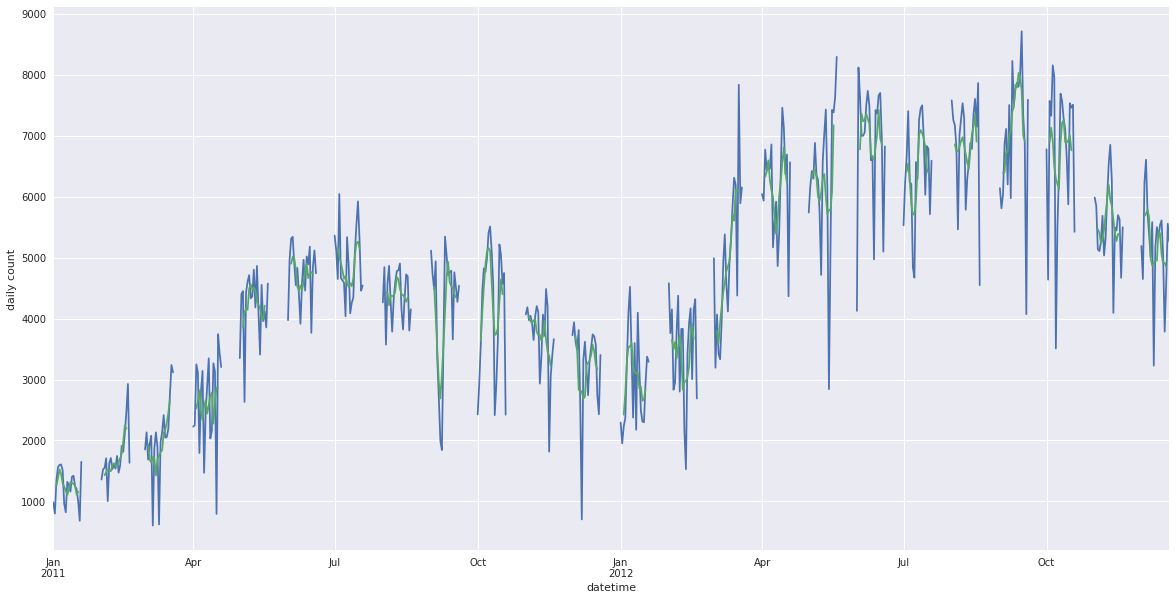

In [4]:
plt.figure(figsize=(20,10))
daily = target.resample('D').sum()
daily.plot()
daily.rolling(5, center=True).mean().plot()
plt.ylabel('daily count')

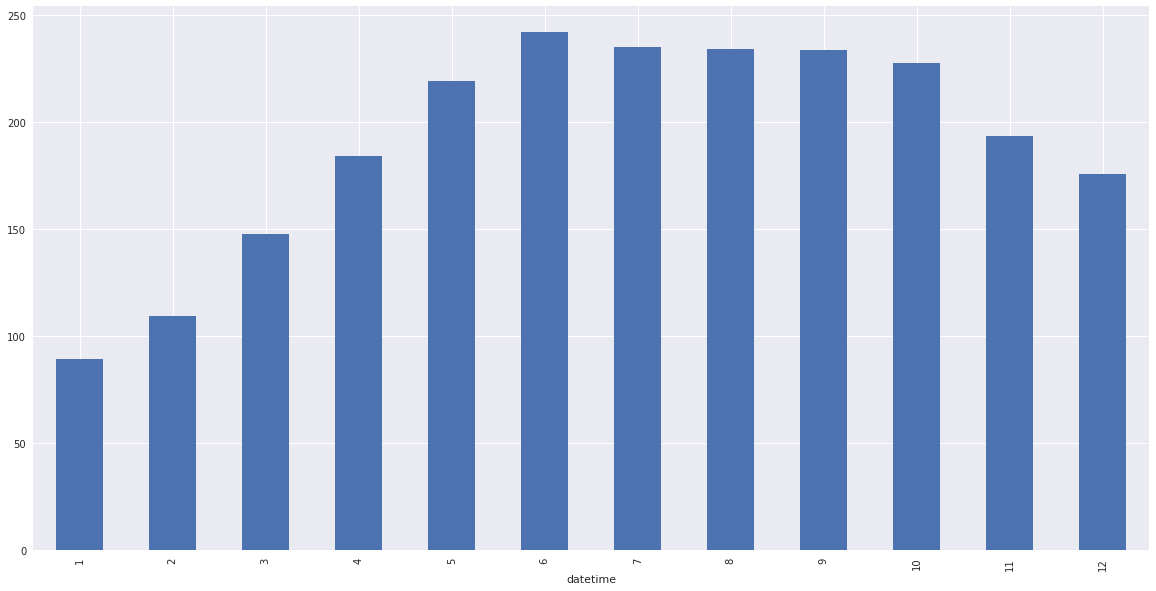

In [5]:
plt.figure(figsize=(20, 10))
monthly = target.resample('M').mean()
monthly.groupby(monthly.index.month).mean().plot(kind='bar')

In [6]:
hourly_ticks = 4 * 60 * 60 * np.arange(6)
dayofweek = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
seasons = ['spring', 'summer', 'fall', 'winter']

[Text(0,0,'00:00:00'),
 Text(0,0,'01:00:00'),
 Text(0,0,'02:00:00'),
 Text(0,0,'03:00:00'),
 Text(0,0,'04:00:00'),
 Text(0,0,'05:00:00'),
 Text(0,0,'06:00:00'),
 Text(0,0,'07:00:00'),
 Text(0,0,'08:00:00'),
 Text(0,0,'09:00:00'),
 Text(0,0,'10:00:00'),
 Text(0,0,'11:00:00'),
 Text(0,0,'12:00:00'),
 Text(0,0,'13:00:00'),
 Text(0,0,'14:00:00'),
 Text(0,0,'15:00:00'),
 Text(0,0,'16:00:00'),
 Text(0,0,'17:00:00'),
 Text(0,0,'18:00:00'),
 Text(0,0,'19:00:00'),
 Text(0,0,'20:00:00'),
 Text(0,0,'21:00:00'),
 Text(0,0,'22:00:00'),
 Text(0,0,'23:00:00')]

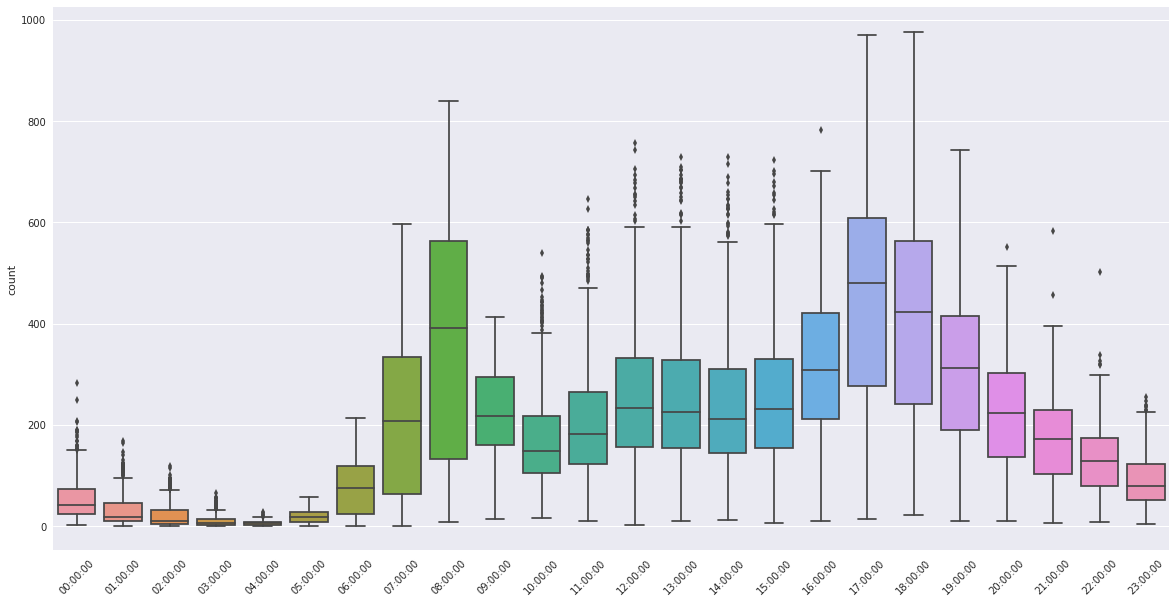

In [7]:
plt.figure(figsize=(20, 10))
g = sns.boxplot(data=data, y='count', x=data.index.time)
g.set_xticklabels(labels=list(data.index.time), rotation=45)

[Text(0,0,'Mon'),
 Text(0,0,'Tues'),
 Text(0,0,'Wed'),
 Text(0,0,'Thur'),
 Text(0,0,'Fri'),
 Text(0,0,'Sat'),
 Text(0,0,'Sun')]

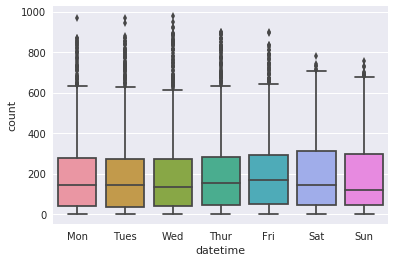

In [8]:
plt.figure()
g = sns.boxplot(data=data, y='count', x=data.index.dayofweek)
g.set_xticklabels(labels=dayofweek)

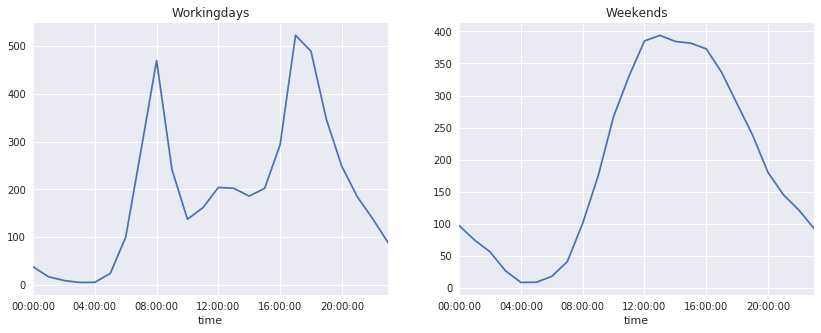

In [10]:
weekend = np.where(target.index.weekday < 5, 'Workday', 'Weekend')
by_time = target.groupby([weekend, target.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Workday'].plot(ax=ax[0], title='Workingdays', xticks=hourly_ticks)
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks)

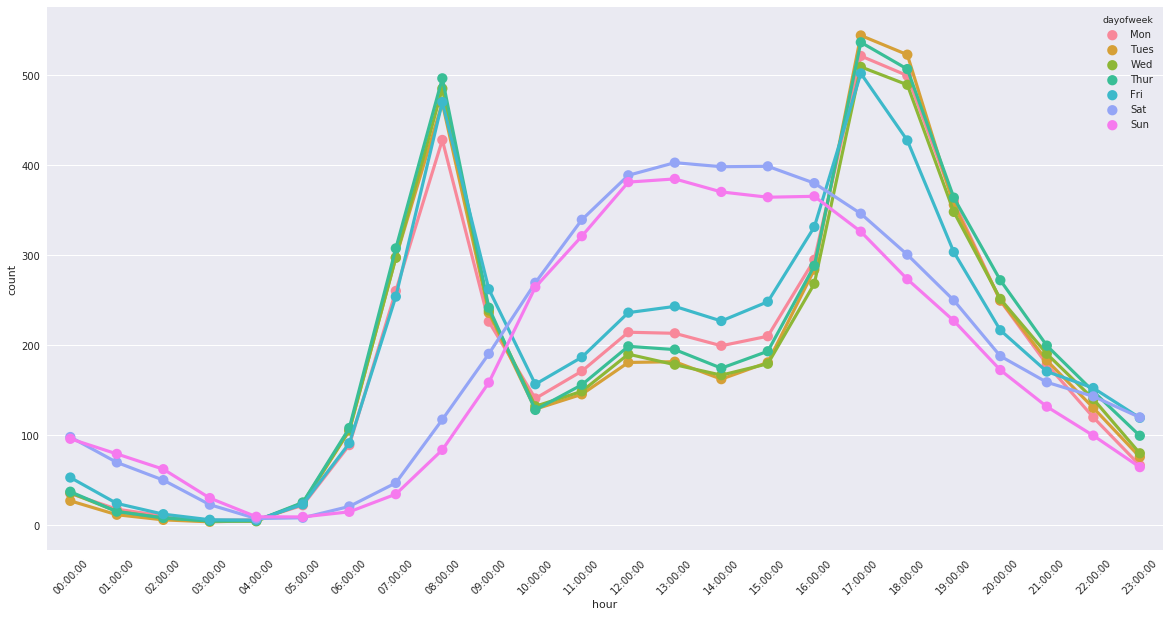

In [12]:
hour_agg_weekday = pd.DataFrame(data.groupby([data.index.dayofweek, data.index.time])['count'].mean()).reset_index()
hour_agg_weekday.rename(columns={'datetime': 'dayofweek', 'level_1': 'hour'}, inplace=True)

plt.figure(figsize=(20, 10))
g = sns.pointplot(x=hour_agg_weekday['hour'], y=hour_agg_weekday['count'], hue=hour_agg_weekday['dayofweek'],
                  data=hour_agg_weekday, join=True)
g.set_xticklabels(labels=data.index.time, rotation=45)
leg = g.get_legend()
for t, l in zip(leg.texts, dayofweek):
    t.set_text(l)

[Text(0,0,'spring'), Text(0,0,'summer'), Text(0,0,'fall'), Text(0,0,'winter')]

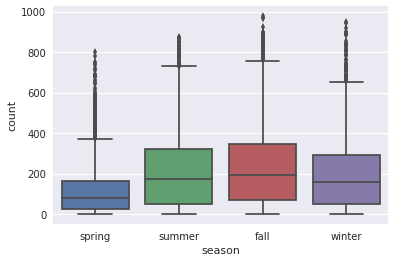

In [13]:
plt.figure()
g = sns.boxplot(data=data, y='count', x='season')
g.set_xticklabels(labels=seasons)

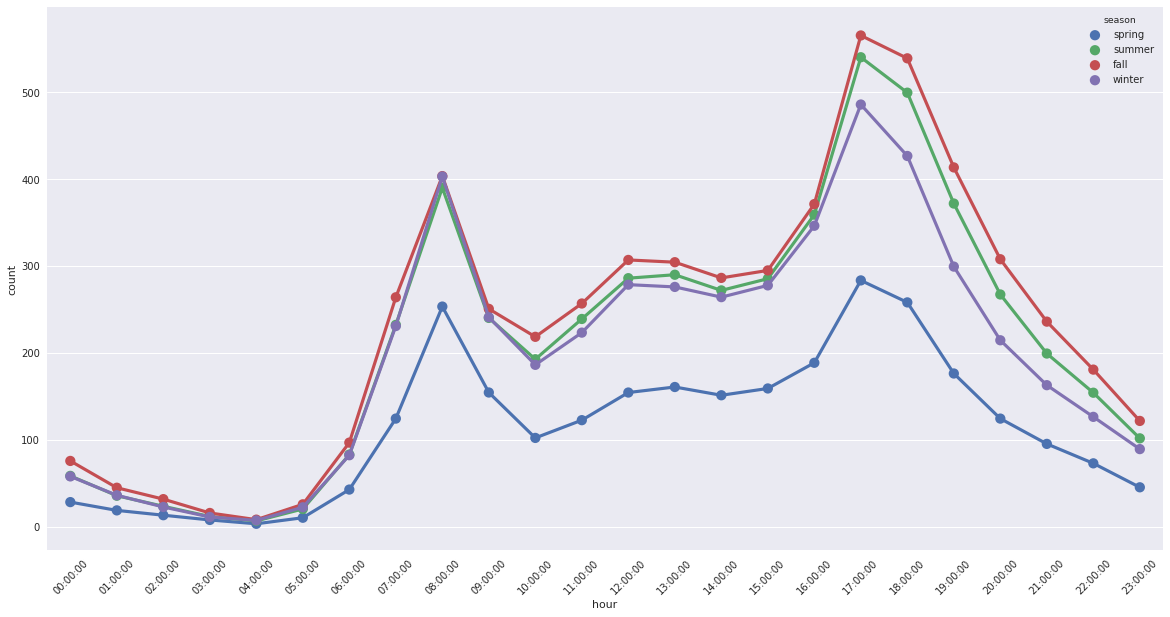

In [14]:
hour_agg = pd.DataFrame(data.groupby(['season', data.index.time])['count'].mean()).reset_index()
hour_agg.rename(columns={'level_1': 'hour'}, inplace=True)

plt.figure(figsize=(20, 10))
g = sns.pointplot(x=hour_agg['hour'], y=hour_agg['count'], hue=hour_agg['season'], data=hour_agg, join=True)
g.set_xticklabels(labels=data.index.time, rotation=45)
leg = g.get_legend()
for t, l in zip(leg.texts, seasons):
    t.set_text(l)

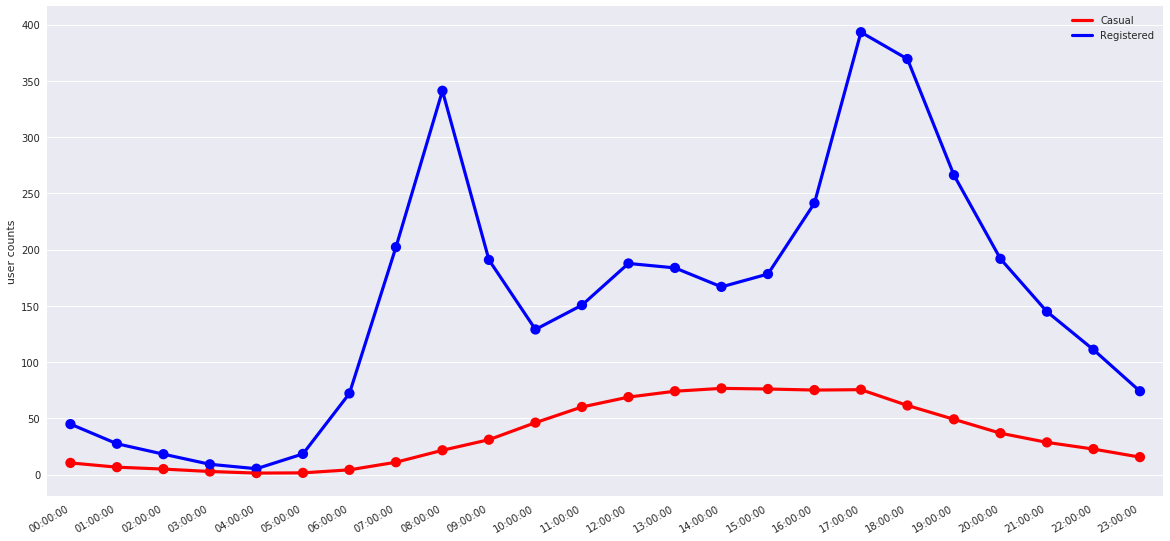

In [15]:
hour_casual = pd.DataFrame(data.groupby([data.index.time])['casual'].mean())
hour_reg = pd.DataFrame(data.groupby([data.index.time])['registered'].mean())

plt.figure(figsize=(20, 10))
ax = sns.pointplot(x=hour_casual.index, y='casual', data=hour_casual, color='r')
sns.pointplot(x=hour_reg.index, y='registered', data=hour_reg, color='b', ax=ax)
ax.set_xticklabels(labels=data.index.time, rotation=90)
ax.set_ylabel('user counts')

ax.legend(handles=ax.lines[::len(hour_casual)+1], labels=["Casual", "Registered"])
ax.set_xticklabels([t.get_text().split("T")[0] for t in ax.get_xticklabels()])
plt.gcf().autofmt_xdate()

Up to now, we have seen the target label 'count' in different datetime frame, such as in hour, day, month, dayofweek, weekday/weekend, season etc. And the last plot tells us the difference between registered and casual users. 

Next, let us look at the correlation relations between the features and the target label. 

In [16]:
corr_mat = data.corr()
corr_with_count = corr_mat.iloc[-1]
corr_sorted = corr_with_count.sort_values()
print(corr_sorted)

humidity     -0.317371
weather      -0.128655
holiday      -0.005393
workingday    0.011594
windspeed     0.101369
season        0.163439
atemp         0.389784
temp          0.394454
casual        0.690414
registered    0.970948
count         1.000000
Name: count, dtype: float64


It looks like the feature 'holiday' is not so important, and the features 'temp' and 'atemp' carry the same information, recall that 'atemp' is the feel-like temperature. We plot a heatmap without the features 'holiday' and 'atemp'. 

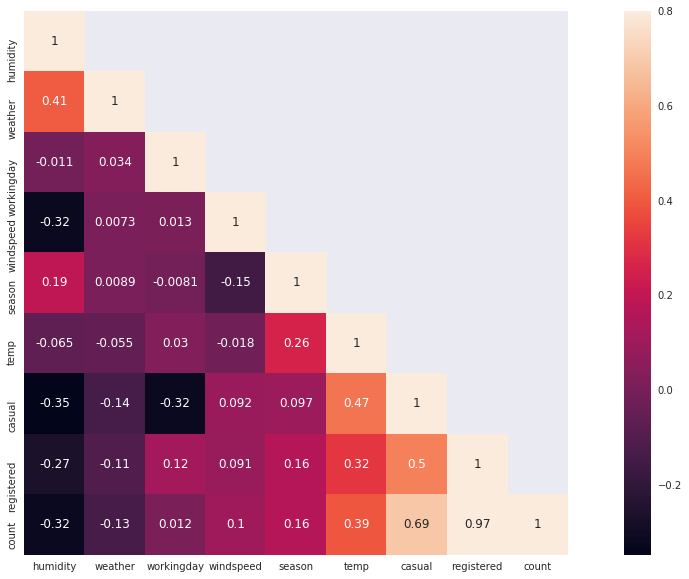

In [17]:
features_sorted = list(corr_sorted.index)
features_sorted.remove('holiday')
features_sorted.remove('atemp')


corr_mat_heat = data[features_sorted].corr()
mask = np.array(corr_mat_heat)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr_mat_heat, mask=mask, vmax=.8, square=True, annot=True)

To see the relation between each feature and the target label, one can try pairplot or regplot. Here we give the regplot of the feature 'windspeed'.

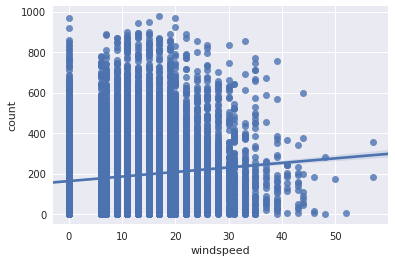

In [18]:
sns.regplot(x='windspeed', y='count', data=data)

It is a common pratice to use the log function in normalizing data. 

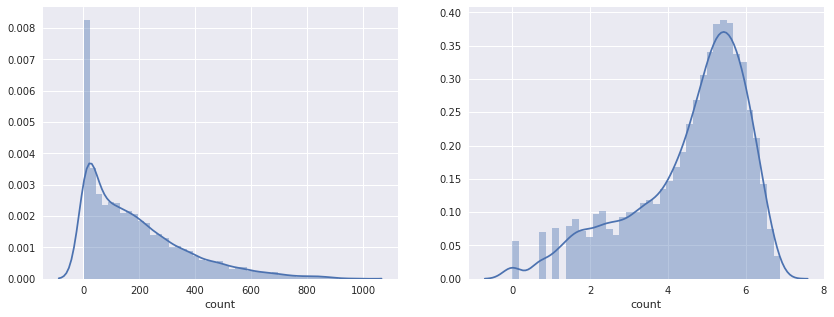

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
ax = ax.ravel()
sns.distplot(data['count'], ax=ax[0])
sns.distplot(np.log(data['count']), ax=ax[1])

Now we define the RSMLE function for further use. 

In [20]:
def rmsle(p, a):
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in p]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in a]))
    sq = (log1 - log2) ** 2
    err = np.sqrt(np.mean(sq))

    return err

Finally, we train the data using Random Forest, which turns out to be a good estimator. 

In [21]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.csv', index_col='datetime', parse_dates=True)
df['hour'] = df.index.hour

X = df.drop(['casual', 'registered', 'count'], axis=1)
y = df['count'].values

X_train, X_val, y_train, y_val = train_test_split(X, y,  random_state=42)

The key step here is to add a new feature 'hour' into the dataframe.

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train, np.log1p(y_train))
y_pred = forest.predict(X_val)
print('RMSLE score of Random Forest on the validation set:    ', rmsle(np.exp(np.log1p(y_pred)), np.log1p(y_val)))
print('Accuracy score of Random Forest on the validation set: ', forest.score(X_val, np.log1p(y_val)))

RMSLE score of Random Forest on the validation set:     0.21309881823323107
Accuracy score of Random Forest on the validation set:  0.9102997761738827


Here we also compare the RMSLE with the usual accuracy score. We also give the feature importance of this random forest.

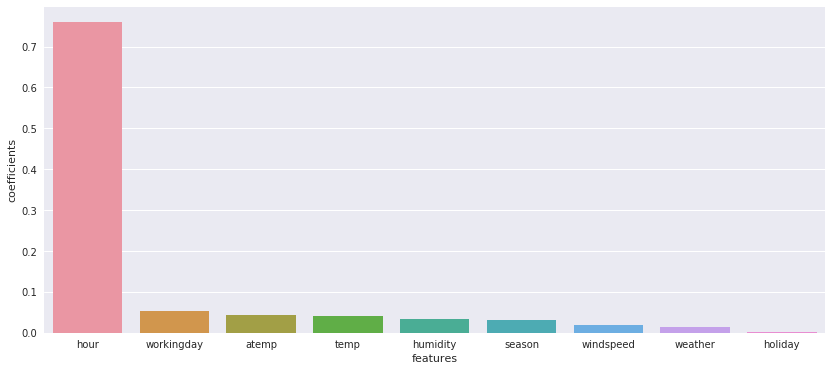

In [24]:
features = pd.DataFrame()
features['features'] = X_train.columns
features['coefficients'] = forest.feature_importances_
features.sort_values(by=['coefficients'], ascending=False, inplace=True)
plt.figure(figsize=(14, 6))
sns.barplot(data=features, x="features", y="coefficients")